In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
a = np.zeros((2, 2), order = 'F')
a[1][1] = 1
a = np.where(a==0, np.inf, a)
a

array([[inf, inf],
       [inf,  1.]])

In [ ]:
class NpSqrGraph:

    def __init__ (self, size:int):
        self.size = size
        self.delmat = np.zeros((4, size**2), order='F')     #строки матрицы соотвествуют задержке при переходе вверх, вниз, вправо и влево. inf соотвествует отсутствию узла в соотвествующем направлении. Столбцы соответствуют узлам, нумерация по столбцам сверху вниз.
        

    def connect (self, delay:list):
        if len(delay) != 2*self.size*(self.size - 1):
            print( 'delay list length must be', 2*self.size*(self.size - 1))
        else:
            for i in range (0, self.size*(self.size - 1)):
                self.delmat[1][i + int(i/(self.size - 1))] = self.delmat[0][i + int(i/(self.size - 1)) + 1] = delay[i]     #присваивание задержек вертикальным ребрам (нумерация по столбцам). Каналы считаются симметричными.
                self.delmat[2][i] = self.delmat[3][i + self.size] = delay[i + self.size*(self.size - 1)]     #присваивание задержек вертикальным ребрам (нумерация по столбцам). Каналы считаются симметричными.
            self.delmat = np.where(self.delmat == 0, np.inf, self.delmat) 

    def dkspreparation (self):
        self.dks = np.zeros((3, self.size**2), order='F') #первая строка - флаг посещения вершины, вторая - текущая метка вершины, третья - путь, которым получена метка.
        for i in self.dks[1]:
            i = np.inf


In [ ]:
class SqrGraph:

    def __init__ (self, size: int):
        self.size = size
        self.delays = []
        
        
    def delay_init (self, delays):
        if len(delays) != 2*self.size*(self.size - 1):
            print( 'delay list length must be', 2*self.size*(self.size - 1))
        else:
            for i in range (self.size**2):
                self.delays += [[0, 0, 0, 0]]
            for i in range (0, self.size*(self.size - 1)):
                self.delays[i + int(i/(self.size - 1))][1] = self.delays[i + int(i/(self.size - 1)) + 1][0] = delays[i]     #присваивание задержек вертикальным ребрам (нумерация по столбцам). Каналы считаются симметричными.
                self.delays[i][2] = self.delays[i + self.size][3] = delays[i + self.size*(self.size - 1)]    
            for i in range (self.size):
                self.delays[i][3] = self.delays[i*self.size][0] = self.delays[i*self.size - 1][1] = self.delays[self.size*(self.size - 1)+i][2] = None
            
    def deykstra (self, start: int):
        



In [15]:
from random import randint

net2 = SqrGraph(3)
delay =[]
for i in range (12):
    delay += [randint(1, 6)]
net2.delay_init(delay)
print(net2.delays)


[[None, 5, 2, None], [5, 2, 1, None], [2, None, 5, None], [None, 3, 4, 2], [3, 5, 2, 1], [5, None, 4, 5], [None, 6, None, 4], [6, 2, None, 2], [2, None, None, 4]]


In [124]:
from queue import Queue
class SqrVertex:                        #класс, описывающий вершину графа (маршрутизатор)

    def __init__(self, x: int, y: int, delays = [0, 0, 0, 0]):
        self.x = x                      #номер строки вершины
        self.y = y                      #номер столбца вершины
        self.delays = delays            #задержки по различным направлениям (веса ребер) в порядке: вверх, вниз, влево, вправо
        self.flag = 0                   #флаг, чтобы отмечать вершину как посещенную при обходе Дейкстрой
        self.distance = float('inf')    #расстояние от какой-то выбранной вершины до данной
        self.ways = []                  #массив с путями к другим вершинам
        self.parent = 0                 #предшествующая вершина (для поиска в ширину)

class SqrNet:                           #класс, описывающий квадратную сеть

    def __init__(self, N: int, delays: list):           #delays состоит из двух подмассивов - горизонтальные и вертикальные ребра. В каждом из подмассивов ребра занумерованы двумя индексами: строка+столбец (или столбец+строка)

        if len(delays) != 2 or len(delays[1]) != N or len(delays[0]) != N: #проверим, что размер массива задержек (весов ребер) имеет корректыные размеры.
            return "delay list size error"
        
        else:
            for i in range (N):
                if len(delays[0][i]) != N-1 or len(delays[1][i]) != N-1: #все еще проверяем размеры массива. По-хорошему еще бы положительность всех задержек проверять, иначе Дейкстра некорректен.
                  return "delay list size error"  
            self.delays = delays
            self.size = N
            self.vert_list = []         #это массив с вершинами
            for i in range (N):
                self.vert_list += [[]]
                for j in range (N):
                    self.vert_list[i] += [0]
                    self.vert_list[i][j] = SqrVertex(i, j, delays = [float('inf'), float('inf'), float('inf'), float('inf')]) #инициализация вершин, по умолчанию все задержки бесконечны (граф несвязен)
            
            for i in range (N):
                    for j in range (N-1):
                        self.vert_list[i][j].delays[3] = self.vert_list[i][j+1].delays[2] = delays[0][i][j] #здесь присваиваем задержки. Предполагается, что каналы симметричны (задержка из а в b равна задержке из b в а)
                        self.vert_list[j][i].delays[1] = self.vert_list[j+1][i].delays[0] = delays[1][i][j]
    
    def step(self, start: SqrVertex, direction: int):           #операция "шага" в определенном направлении (0 - вверх, 1 - вниз, 2 - влево, 3 - вправо)
        if direction == 0 and start.delays[0]<float('inf'):     #сделал, потому что показалось удобным, хотя, возможно, это неоптимально
            return self.vert_list[start.x - 1][start.y]         #
        elif direction == 1 and start.delays[1]<float('inf'):
            return self.vert_list[start.x + 1][start.y]
        elif direction == 2 and start.delays[2]<float('inf'):
            return self.vert_list[start.x][start.y - 1]
        elif direction == 3 and start.delays[3]<float('inf'):
            return self.vert_list[start.x][start.y+1]
                              

    def dijkstra (self, start_x: int, start_y: int):                                           #собственно, алгоритм Дейкстры
        if not((start_x<self.size and start_x > -1) and (start_y<self.size and start_y > -1)): #проверка корректности координат вершины, относительно которой вычисляются пути
            return "no vertex with such coordinates"
        else:
            for i in self.vert_list: 
                    for j in i:
                        j.distance = float('inf')                   #сбрасываем все distancы и flagи в бесконечность (они могли быть изменены предыдущим вызовом Дейкстры)
                        j.flag = 0
            start = self.vert_list[start_x][start_y]                #определение отправной вершины (расстояние до/от которой считаем)
            start.distance = 0
            start.ways = []
            for i in range (self.size):                             #формирование массива путей. Он организован как матрица, где ij-ой вершине соотвествует ij-ый массив из элементов {0, 1, 2, 3}  
                start.ways += [[]]                                  #отражающих движение на каждом шаге {вверх, вниз, влево, вправо} соотвественно. Последним элементом массива пути до вершины будет его длина.
                for j in range (self.size):
                    start.ways[i] += [[]]
            next_vert = self.vert_list[start_x - 1][start_y - 1]    #"затравка" для начала первой итерации Дейкстры
            #подготовка к выполнению алгоритма завершена

            for k in range (self.size**2):                          #обходим все вершины
                for i in self.vert_list:
                    for j in i:
                        if j.flag == 0:
                            if j.distance < next_vert.distance:
                                next_vert = j                       #выбор еще не посещенной вершины с минимальным расстоянием до стартовой
                for i in range (4):                                 #обходим все непосещенные соседние вершины
                    if type(self.step(next_vert, i)) == SqrVertex:  #step может ничего не вернуть (например, если шаг был сделан за пределы графа). Отфильтруем содержательные случаи
                        if self.step(next_vert, i).distance > next_vert.distance + next_vert.delays[i] and self.step(next_vert, i).flag == 0: #проверка, оказался ли данный путь короче уже существующих
                            self.step(next_vert, i).distance = next_vert.distance + next_vert.delays[i] #присваивание вершине нового (меньшего) расстояния
                            next_vert_1 = self.step(next_vert, i) 
                            start.ways[next_vert_1.x][next_vert_1.y] = start.ways[next_vert.x][next_vert.y] + [i] #корректеровка кратчайшего пути до вершины
                next_vert.flag = 1                                  #поднятие флага о посещении вершины
                start.ways[next_vert.x][next_vert.y].append(next_vert.distance) #путь до посещенной вершины больше не будет меняться, поэтому в конце добавим его длину, чтобы освободить distance для дальнейших выполнений алгоритма
                next_vert = next_vert_1                             #переопределение потенциально следующей вершины
                

    def BFS(self, start_x, start_y):
        if not((start_x<self.size and start_x > -1) and (start_y<self.size and start_y > -1)): #проверка корректности координат вершины, относительно которой вычисляются пути
                return "no vertex with such coordinates"
        else:
            for i in self.vert_list: 
                    for j in i:
                        j.distance = float('inf')                   #сбрасываем все distancы и flagи в бесконечность (они могли быть изменены предыдущим вызовом Дейкстры)
                        j.flag = 0                                  #вместо окраски вершин присваиваются значения flag = {0, 1, 2} для непосещенной, посещенной с непосещенными соседями и посещенной с посещенными соседями соотвественно
                        j.parent = None 
                    
            start = self.vert_list[start_x][start_y]                #определение отправной вершины (расстояние до/от которой считаем)
            start.distance = 0
            start.flag = 1
            start.ways = []
            for i in range (self.size):                             #формирование массива путей. Он организован как матрица, где ij-ой вершине соотвествует ij-ый массив из элементов {0, 1, 2, 3}  
                start.ways += [[]]                                  #отражающих движение на каждом шаге {вверх, вниз, влево, вправо} соотвественно. Последним элементом массива пути до вершины будет его длина.
                for j in range (self.size):
                    start.ways[i] += [[]]
            Q = Queue()
            Q.put(start)
            while not(Q.empty()):
                current_vert = Q.get()
                for i in range(4):
                    a = self.step(current_vert, i) #чтобы не вызывать функцию step несколько раз
                    if type(a) == SqrVertex:
                        if a.flag == 0:
                            a.flag = 1
                            a.distance = current_vert.distance + 1
                            a.parent = current_vert
                            start.ways[a.x][a.y] = start.ways[current_vert.x][current_vert.y] + [i]  
                            Q.put(a)
                current_vert.flag = 2
                start.ways[current_vert.x][current_vert.y] = start.ways[current_vert.x][current_vert.y] + [current_vert.distance]
                





            
                    

        


In [125]:

N = 3
delays = [[],[]]
for i in range (N):
    delays[0] += [[]]
    delays[1] += [[]]
    for j in range (N-1):
        delays[0][i] += [0]
        delays[1][i] += [0]

for i in range (N):
    for j in range (N-1):
        delays[0][i][j] = (N-1)*i+j+1
        delays[1][i][j] = (N-1)*i+j + N*(N-1)+1
        


print (delays)


net3 = SqrNet(N, delays)
#print(net3.vert_list)
print(net3.delays)
'''for i in net3.vert_list:
    for j in i:
        print(j.delays, '\n', '\n')'''
net3.dijkstra(N-1,N-1)
print(net3.vert_list[N-1][N-1].ways)
net3.BFS(N-1,N-1)
print(net3.vert_list[N-1][N-1].ways)
for i in range (N):
    for j in range (N):
        print(net3.vert_list[i][j].distance, '\n', '\n')

#print(float('inf')>5)


[[[1, 2], [3, 4], [5, 6]], [[7, 8], [9, 10], [11, 12]]]
[[[1, 2], [3, 4], [5, 6]], [[7, 8], [9, 10], [11, 12]]]
[[[2, 2, 0, 0, 26], [2, 0, 0, 25], [0, 0, 23]], [[2, 2, 0, 19], [2, 0, 16], [0, 12]], [[2, 2, 11], [2, 6], [0]]]
[[[0, 0, 2, 2, 4], [0, 0, 2, 3], [0, 0, 2]], [[0, 2, 2, 3], [0, 2, 2], [0, 1]], [[2, 2, 2], [2, 1], [0]]]
4 
 

3 
 

2 
 

3 
 

2 
 

1 
 

2 
 

1 
 

0 
 



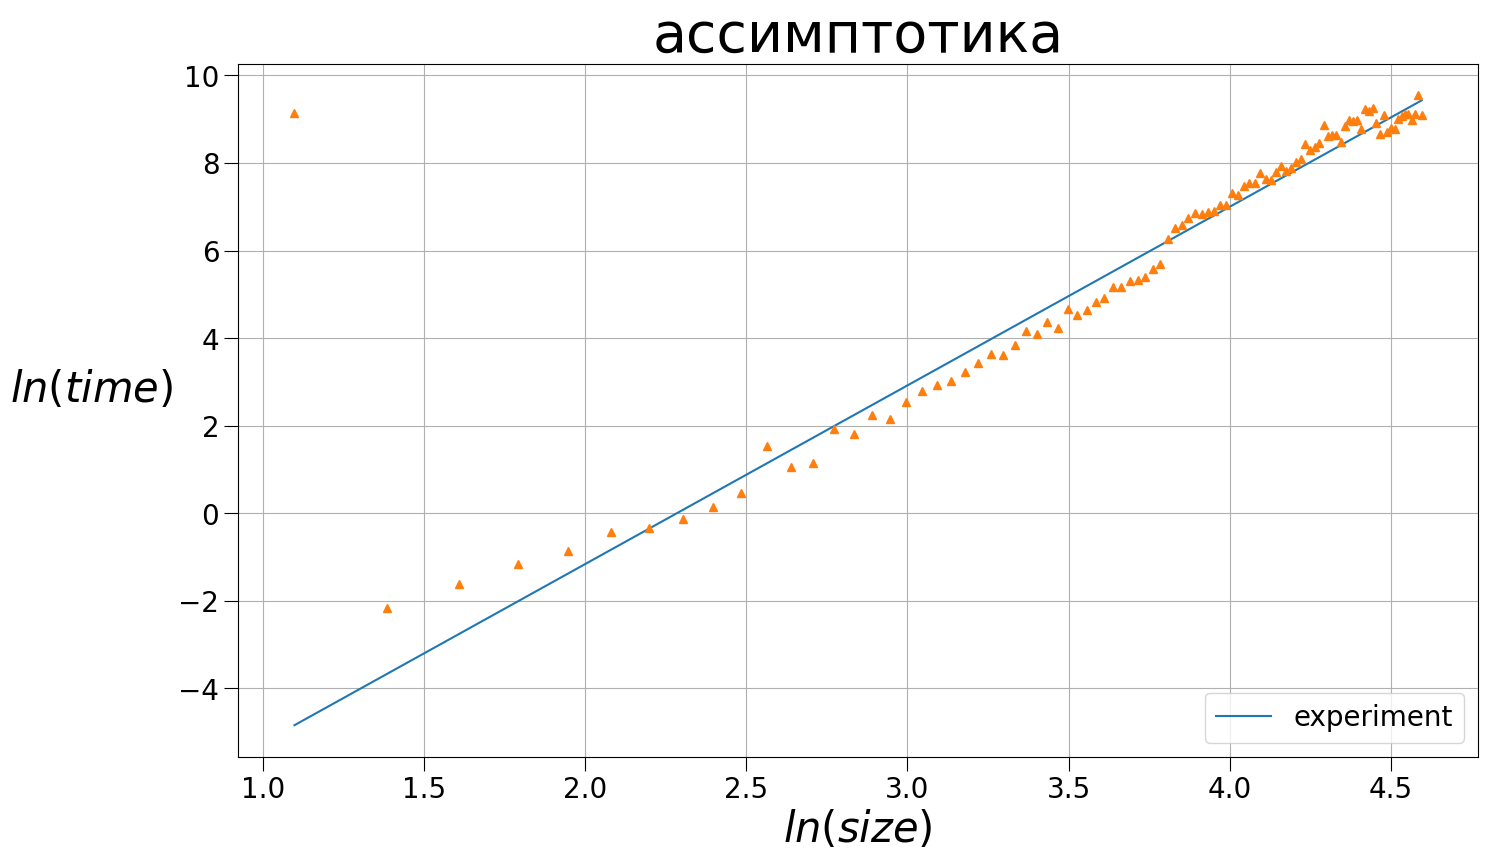

4.081375090788731

In [38]:
import timeit
from random import randint
import csv
#import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


time_data = [['N', 'time, ms']]
size = []
time = []
for N in range (3, 100):
    
    delays = [[],[]]
    for i in range (N):
        delays[0] += [[]]
        delays[1] += [[]]
        for j in range (N-1):
            delays[0][i] += [randint(2, 10)]
            delays[1][i] += [randint(2, 10)]
    t = timeit.timeit(lambda: net3.dijkstra(2,2), number=1)*1000
    net3 = SqrNet(N, delays)
    time_data += [[N, t]]
    size += [np.log(N)]
    time += [np.log(t)]




csv.writer(open('time_data.csv', 'w', newline ='')).writerows(time_data)





z1 = np.polyfit(size[1:], time[1:], deg = 1)
y1 = np.poly1d(z1)


fig, ax = plt.subplots(figsize=(16,9))
plt.title("ассимптотика", fontsize = 40)
ax.plot(size, y1(size), label = 'experiment')
ax.errorbar(size, time, fmt='^')
ax.grid()
ax.legend()
plt.legend(fontsize = 20)
plt.xlabel('$ln(size)$', fontsize = 30)
plt.ylabel("$ln(time)$", rotation=0, horizontalalignment='right',fontsize = 30)
plt.tick_params('both', size = 10, labelsize = 20)
plt.show()
#df = pd.read_csv('time_data.csv')
z1[0]

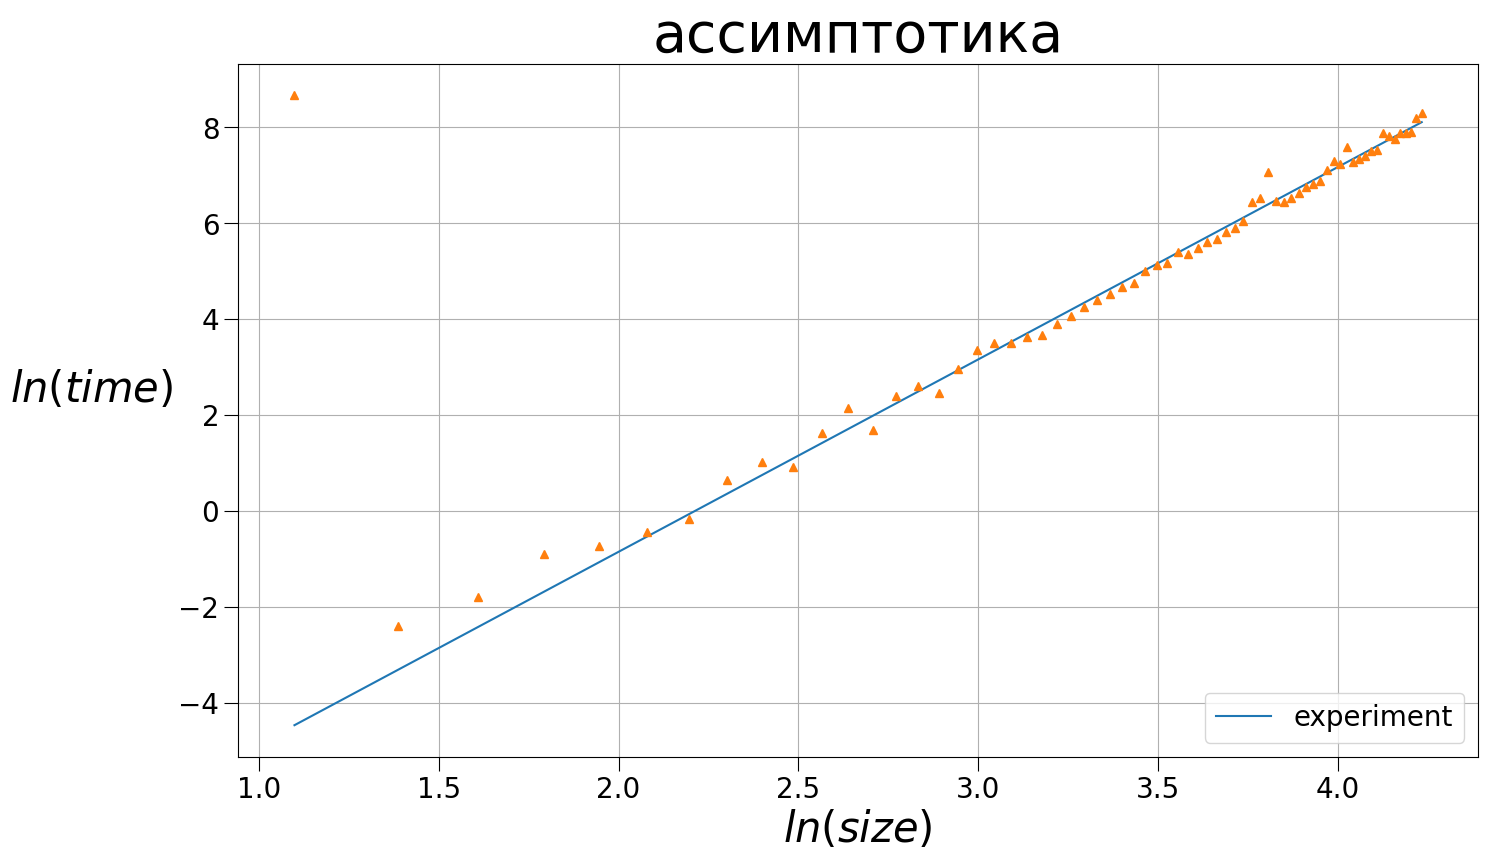

4.01060272400328

In [36]:
z1 = np.polyfit(size[10:], time[10:], deg = 1)
y1 = np.poly1d(z1)


fig, ax = plt.subplots(figsize=(16,9))
plt.title("ассимптотика", fontsize = 40)
ax.plot(size, y1(size), label = 'experiment')
ax.errorbar(size, time, fmt='^')
ax.grid()
ax.legend()
plt.legend(fontsize = 20)
plt.xlabel('$ln(size)$', fontsize = 30)
plt.ylabel("$ln(time)$", rotation=0, horizontalalignment='right',fontsize = 30)
plt.tick_params('both', size = 10, labelsize = 20)
plt.show()
#df = pd.read_csv('time_data.csv')
z1[0]